# Task 1: Exploratory Data Analysis (EDA)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   CustomerID    200 non-null    object
 1   CustomerName  200 non-null    object
 2   Region        200 non-null    object
 3   SignupDate    200 non-null    object
dtypes: object(4)
memory usage: 6.4+ KB
None 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ProductID    100 non-null    object 
 1   ProductName  100 non-null    object 
 2   Category     100 non-null    object 
 3   Price        100 non-null    float64
dtypes: float64(1), object(3)
memory usage: 3.3+ KB
None 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------

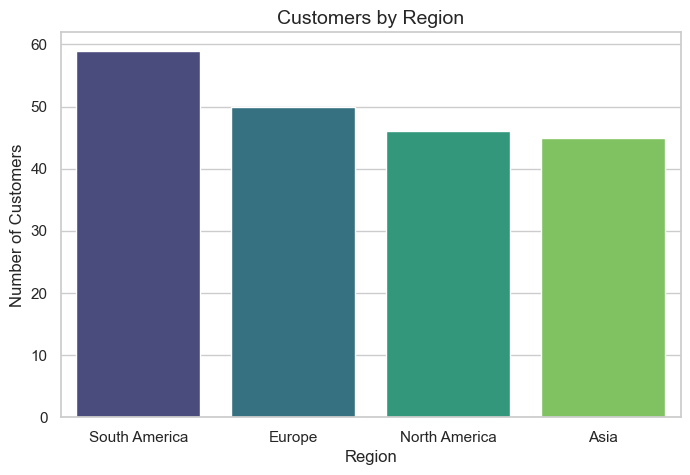

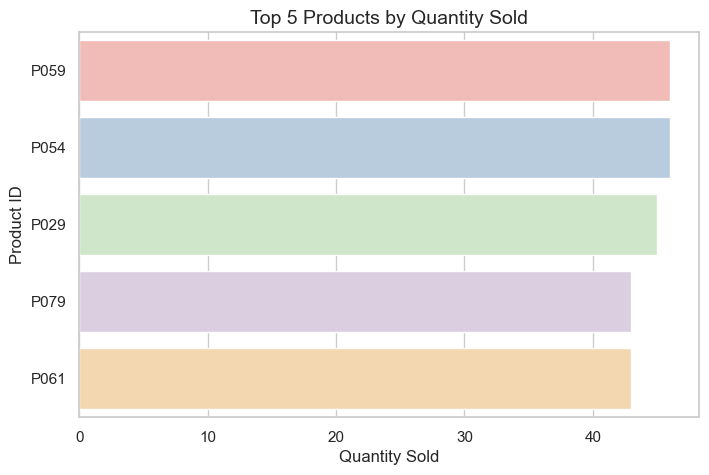

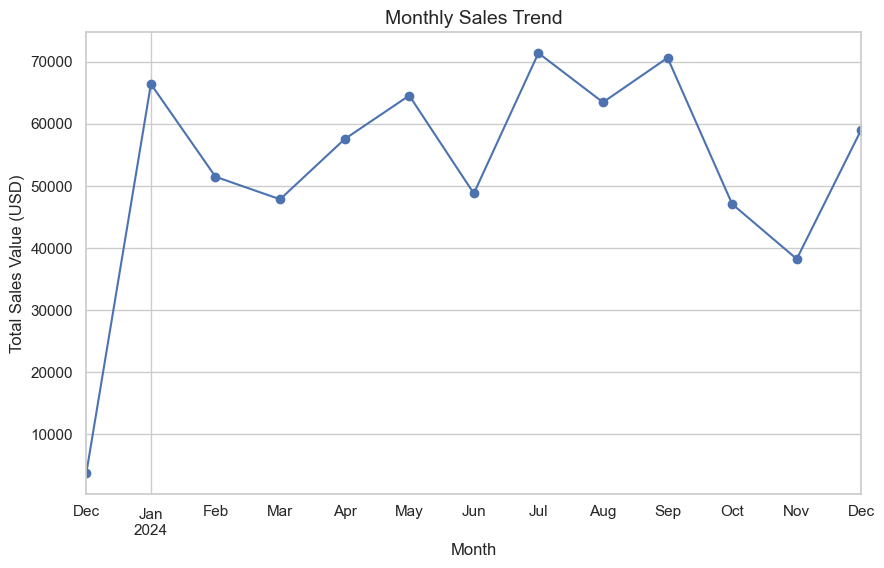

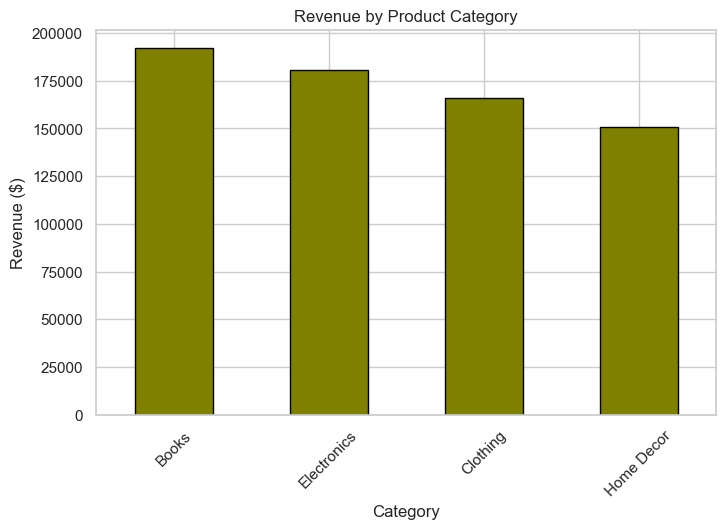

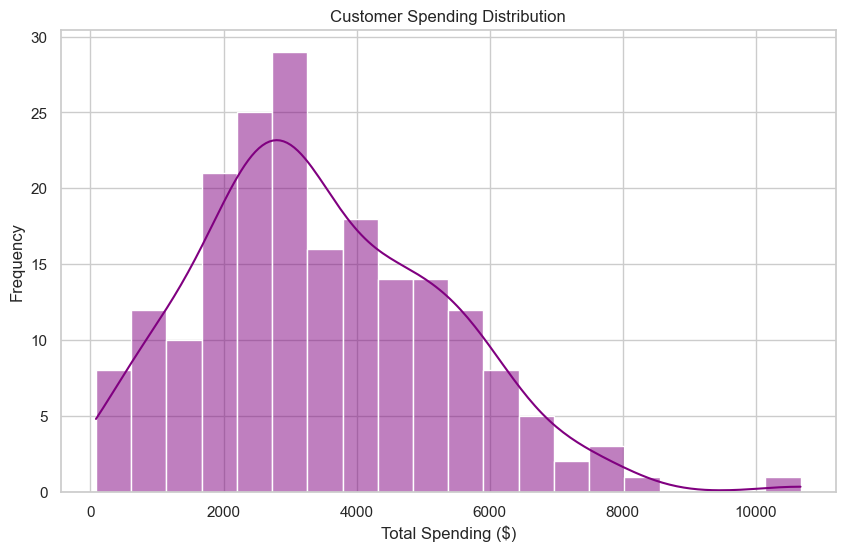

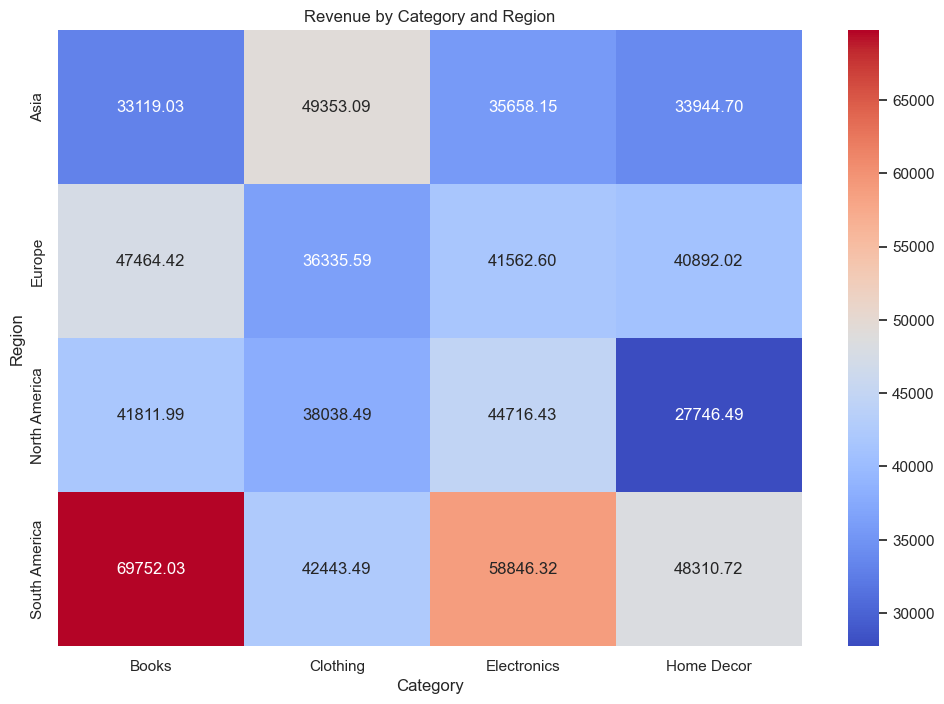

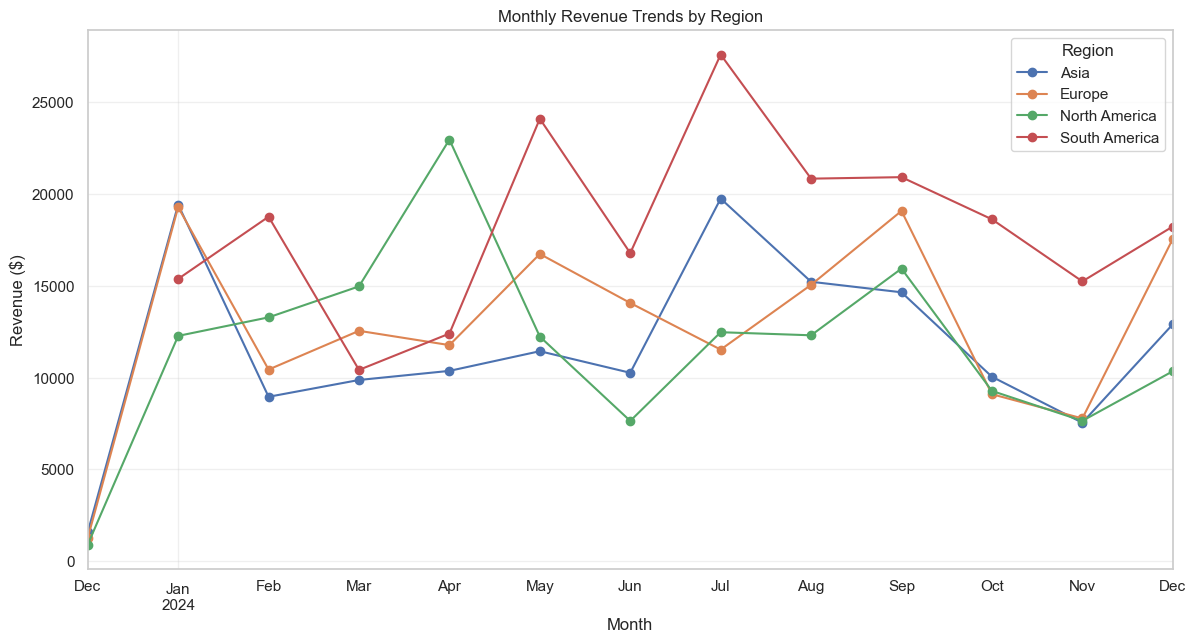

In [32]:
# Data Science Assignment: eCommerce Transactions Analysis

import os
os.environ["OMP_NUM_THREADS"] = "1"

# Importing necessary libraries

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score

sns.set(style="whitegrid")

# Loading the datasets
customers = pd.read_csv("Customers.csv")
products = pd.read_csv("Products.csv")
transactions = pd.read_csv("Transactions.csv")
# Displaying the first few rows of each dataset to understand their structure
customers_head = customers.head()
products_head = products.head()
transactions_head = transactions.head()
# Inspect datasets
print(customers.info(),"\n")
print(products.info(),"\n")
print(transactions.info())
# Data Cleaning
# Converting date columns to datetime
customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])
print(customers.isnull().sum(),"\n")
print(products.isnull().sum(),"\n")
print(transactions.isnull().sum(),"\n")
print(customers.describe(include='all'),"\n")
print(products.describe(include='all'),"\n")
print(transactions.describe(include='all'),"\n")
print(customers.duplicated().sum(),"\n",
      products.duplicated().sum(),"\n",
      transactions.duplicated().sum())
print(customers.columns.tolist(),"\n\n",
products.columns.tolist(),"\n\n",
transactions.columns.tolist())
print(customers.shape,"\n",
products.shape,"\n",
transactions.shape)
# Analyzing customers by region
customers_by_region = customers['Region'].value_counts()

customers_by_region.head()
# Analyzing top-selling products and categories by quantity sold
top_products = transactions.groupby('ProductID')['Quantity'].sum().sort_values(ascending=False).head(5)
top_categories = products.loc[products['ProductID'].isin(top_products.index), 'Category'].value_counts()

print(top_products.head(),"\n\n", 
      top_categories.head())
# Analyzing transaction trends over time (Monthly)
transactions['TransactionMonth'] = transactions['TransactionDate'].dt.to_period('M')
monthly_sales = transactions.groupby('TransactionMonth')['TotalValue'].sum()

monthly_sales
# Revenue by product category

category_revenue = (transactions.merge(products, on='ProductID').groupby('Category')['TotalValue'].sum().sort_values(ascending=False))
category_revenue
# Customer spending distribution

customer_spending = transactions.groupby('CustomerID')['TotalValue'].sum()
print(customer_spending.describe())
# Plotting Customers by Region
plt.figure(figsize=(8, 5))
sns.barplot(x=customers_by_region.index, y=customers_by_region.values, palette='viridis',hue=customers_by_region.index,legend=False)
plt.title("Customers by Region", fontsize=14)
plt.xlabel("Region", fontsize=12)
plt.ylabel("Number of Customers", fontsize=12)
plt.show()

# Plotting Top 5 Products by Quantity Sold
plt.figure(figsize=(8, 5))
sns.barplot(x=top_products.values, y=top_products.index, palette='Pastel1',hue=top_products.index, orient="h")
plt.title("Top 5 Products by Quantity Sold", fontsize=14)
plt.xlabel("Quantity Sold", fontsize=12)
plt.ylabel("Product ID", fontsize=12)
plt.show()

# Plotting Monthly Sales Trend
plt.figure(figsize=(10, 6))
monthly_sales.plot(kind="line", marker="o", color="b")
plt.title("Monthly Sales Trend", fontsize=14)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Total Sales Value (USD)", fontsize=12)
plt.grid(True)
plt.show()

# EDA: Revenue by product category
category_revenue = transactions.merge(products, on='ProductID').groupby('Category')['TotalValue'].sum()
plt.figure(figsize=(8, 5))
category_revenue.sort_values(ascending=False).plot(kind='bar', color='olive', edgecolor='black')
plt.title("Revenue by Product Category")
plt.xlabel("Category")
plt.ylabel("Revenue ($)")
plt.xticks(rotation=45)
plt.show()

# EDA: Customer spending distribution
customer_spending = transactions.groupby('CustomerID')['TotalValue'].sum()
plt.figure(figsize=(10, 6))
sns.histplot(customer_spending, kde=True, color='purple', bins=20)
plt.title("Customer Spending Distribution")
plt.xlabel("Total Spending ($)")
plt.ylabel("Frequency")
plt.show()


top_categories_region = transactions.merge(products, on='ProductID').merge(customers, on='CustomerID')
region_category_revenue = top_categories_region.groupby(['Region', 'Category'])['TotalValue'].sum().unstack()

# Heatmap for Revenue by Category and Region
plt.figure(figsize=(12, 8))
sns.heatmap(region_category_revenue, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Revenue by Category and Region")
plt.ylabel("Region")
plt.xlabel("Category")
plt.show()



transactions['TransactionMonth'] = transactions['TransactionDate'].dt.to_period('M')
monthly_region_sales = transactions.merge(customers, on='CustomerID').groupby(['Region', 'TransactionMonth'])['TotalValue'].sum().unstack()

monthly_region_sales.T.plot(figsize=(14, 7), marker='o')
plt.title("Monthly Revenue Trends by Region")
plt.xlabel("Month")
plt.ylabel("Revenue ($)")
plt.legend(title="Region")
plt.grid(alpha=0.3)
plt.show()



## Task 2: Lookalike Model.
Data Merging and Aggregation.

preparing the data for building the model.

In [34]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [35]:
# Merge datasets for Lookalike Model
transactions_products = transactions.merge(products, on="ProductID", how="left")
merged_data = transactions_products.merge(customers, on="CustomerID", how="left")
merged_data.rename(columns={'Price_y': 'Price'}, inplace=True)

# Re-aggregate customer transaction details
customer_summary = merged_data.groupby("CustomerID").agg({
    'TotalValue': 'sum',  # Total transaction value per customer
    'Quantity': 'sum',   # Total quantity purchased per customer
    'Price': 'mean',     # Average price of products purchased
    'Category': lambda x: x.mode()[0]  # Most purchased category
}).reset_index()

In [36]:
# Encode categorical features and standardize numerical ones
customer_summary_encoded = pd.get_dummies(customer_summary, columns=['Category'])
scaler = StandardScaler()
numerical_features = ['TotalValue', 'Quantity', 'Price']
customer_summary_encoded[numerical_features] = scaler.fit_transform(customer_summary_encoded[numerical_features])

In [37]:
# Compute similarity scores for the first 20 customers
first_20_customers = customer_summary_encoded.iloc[:20]
similarity_scores = cosine_similarity(first_20_customers.iloc[:, 1:], customer_summary_encoded.iloc[:, 1:])

# Generate Lookalike recommendations
lookalike_results = {}
for idx, customer_id in enumerate(first_20_customers['CustomerID']):
    similar_customers = sorted(
        list(enumerate(similarity_scores[idx])),
        key=lambda x: x[1],
        reverse=True
    )[1:4]  # Top 3 lookalikes excluding the customer itself
    lookalike_results[customer_id] = [(customer_summary_encoded.iloc[i]['CustomerID'], score) for i, score in similar_customers]

lookalike_results

{'C0001': [('C0069', 0.9324018454753686),
  ('C0154', 0.923507363502334),
  ('C0026', 0.8874896445880608)],
 'C0002': [('C0029', 0.999813684565344),
  ('C0088', 0.984786970122018),
  ('C0062', 0.9810852132937548)],
 'C0003': [('C0038', 0.9938320157333372),
  ('C0160', 0.9439547841946113),
  ('C0189', 0.9272584290424002)],
 'C0004': [('C0075', 0.9890562895786139),
  ('C0041', 0.9830577574234166),
  ('C0175', 0.9826840394401017)],
 'C0005': [('C0192', 0.995718940217707),
  ('C0140', 0.9899379450022263),
  ('C0186', 0.9758473072379672)],
 'C0006': [('C0187', 0.9497359319245032),
  ('C0117', 0.9456213700238187),
  ('C0168', 0.9371224523840914)],
 'C0007': [('C0146', 0.9958711037026335),
  ('C0115', 0.9630039760834646),
  ('C0050', 0.9598404807403083)],
 'C0008': [('C0113', 0.9893602460323576),
  ('C0136', 0.9808325118516203),
  ('C0195', 0.9700783025191715)],
 'C0009': [('C0150', 0.997311664094273),
  ('C0061', 0.972018762628306),
  ('C0198', 0.9360077645399814)],
 'C0010': [('C0176', 0.98

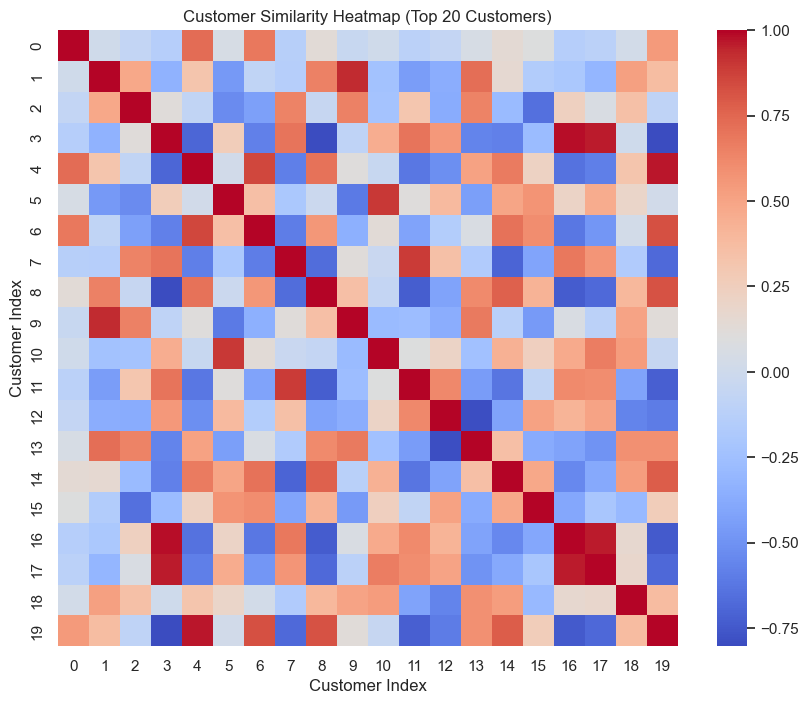

In [38]:
# Added code to generate and save a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_scores[:20, :20], cmap="coolwarm", annot=False, cbar=True)
plt.title("Customer Similarity Heatmap (Top 20 Customers)")
plt.xlabel("Customer Index")
plt.ylabel("Customer Index")
plt.savefig("customer_similarity_heatmap.png")  # Save the visualization
plt.show()


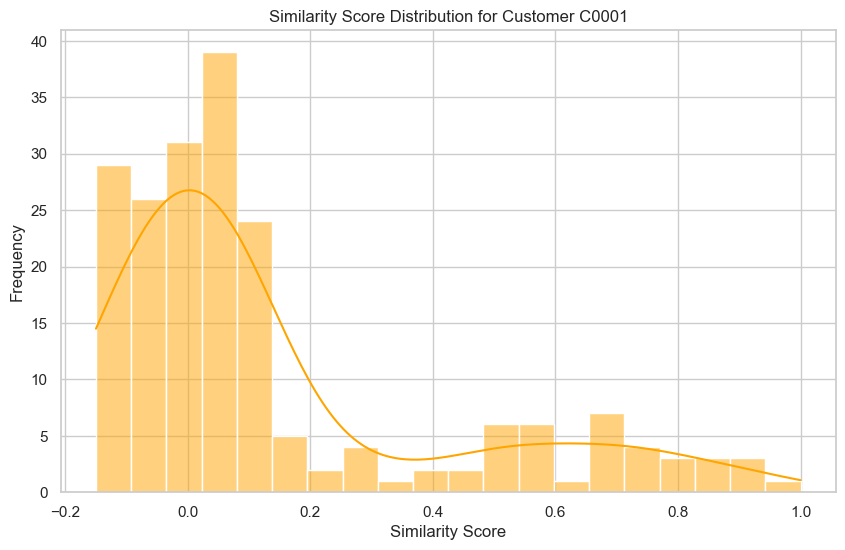

In [39]:
# Example: Distribution of similarity scores for a specific customer
customer_index = 0  # Change index for different customers
plt.figure(figsize=(10, 6))
sns.histplot(similarity_scores[customer_index], bins=20, kde=True, color='orange')
plt.title(f"Similarity Score Distribution for Customer {customer_summary_encoded.iloc[customer_index]['CustomerID']}")
plt.xlabel("Similarity Score")
plt.ylabel("Frequency")
plt.show()



In [40]:
# Generate Lookalike recommendations
lookalike_results = {}
for idx, customer_id in enumerate(first_20_customers['CustomerID']):
    similar_customers = sorted(
        list(enumerate(similarity_scores[idx])),
        key=lambda x: x[1],
        reverse=True
    )[1:4]  # Top 3 lookalikes excluding the customer itself
    lookalike_results[customer_id] = [(customer_summary_encoded.iloc[i]['CustomerID'], score) for i, score in similar_customers]


In [41]:
# Save results to CSV
recommendations_csv = []
for customer, similar_customers in lookalike_results.items():
    for similar_customer, score in similar_customers:
        recommendations_csv.append({
            "CustomerID": customer,
            "SimilarCustomerID": similar_customer,
            "SimilarityScore": score
        })

pd.DataFrame(recommendations_csv).to_csv("lookalike_results.csv", index=False)
print("Lookalike recommendations saved to 'lookalike_results.csv'")

Lookalike recommendations saved to 'lookalike_results.csv'


In [42]:
# Monthly Transactions Trend
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])
transactions['TransactionMonth'] = transactions['TransactionDate'].dt.to_period('M').astype(str)
monthly_trend = transactions.groupby('TransactionMonth').size().reset_index(name='Count')

# Top Product Categories by Total Sales
category_sales = transactions.merge(products, on='ProductID').groupby('Category')['TotalValue'].sum().reset_index()
category_sales = category_sales.sort_values(by='TotalValue', ascending=False)

# Deriving Business Insights

# Insight 1: Customer Region Distribution
region_distribution = customers['Region'].value_counts(normalize=True) * 100

# Insight 2: High Sales Categories
top_category = category_sales.loc[category_sales['TotalValue'].idxmax()]

# Insight 3: Product Pricing
price_stats = products['Price'].describe()

# Insight 4: Monthly Sales Growth
monthly_sales_growth = (monthly_trend['Count'].iloc[-1] - monthly_trend['Count'].iloc[0]) / monthly_trend['Count'].iloc[0] * 100

# Insight 5: Transaction Volume
total_transactions = transactions.shape[0]
avg_transaction_value = transactions['TotalValue'].mean()

region_distribution, top_category, price_stats, monthly_sales_growth, total_transactions, avg_transaction_value


(Region
 South America    29.5
 Europe           25.0
 North America    23.0
 Asia             22.5
 Name: proportion, dtype: float64,
 Category          Books
 TotalValue    192147.47
 Name: 0, dtype: object,
 count    100.000000
 mean     267.551700
 std      143.219383
 min       16.080000
 25%      147.767500
 50%      292.875000
 75%      397.090000
 max      497.760000
 Name: Price, dtype: float64,
 1850.0,
 1000,
 689.9955600000001)